#Logistic Regression (with Regularization)

In this part of the exercise, you will implement regularized logistic regression
to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure
it is functioning correctly.
Suppose you are the product manager of the factory and you have the
test results for some microchips on two different tests. From these two tests,
you would like to determine whether the microchips should be accepted or
rejected. To help you make the decision, you have a dataset of test results
on past microchips, from which you can build a logistic regression model.

###Loading and preprocessing the data

In [756]:
#Let's start from providing Colab access to Google Drive to be able load the file with the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#read data from file
data = pd.read_csv('/content/drive/My Drive/Polynomial/#3_ex2data2.txt', header = None)

In [0]:
#convert data to a torch tensor
data = torch.tensor(data.values).float()

In [0]:
# First, let's split the data to 'inputs'(X) and 'lables'(y)
X = data[:,:2]
y = data[:,2].unsqueeze(1)

###Visualizing the data

Before starting to implement any learning algorithm, it is always good to
visualize the data if possible.

In [0]:
def plotData(X, y):
    plt.scatter(X[:,0][y[:,0]==0], X[:,1][y[:,0]==0], marker = 'x', color = 'red')
    plt.scatter(X[:,0][y[:,0]==1], X[:,1][y[:,0]==1], marker = 'o', color = 'green', alpha = 0.6)
    plt.xlabel('Microchip test_1')
    plt.ylabel('Microchip test_2')
    plt.show

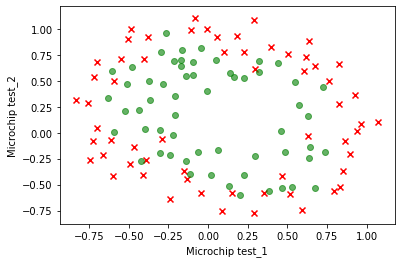

In [762]:
plotData(X, y)

In the above plot green dots specify positive outcome (chips were accepted) and the red once - negative (chips were rejected)

**The objective of this exercise is to build a classification model that will predict whether a chip will be accepted or not, based on the scores of two tests.** 

###Feature mapping

One way to fit the data better is to create more features from each data
point. In the function mapFeature, we will map the features into
all polynomial terms of x1 and x2 up to the some power (degree).

For example, if degree is 6 featureMap(x1, x2) will output a 28-dimensional vector:

output = $\begin{bmatrix} x_1\\x_2 \\ x_1^2\\ x_1x_2\\x_2^2\\x_1^3\\ \vdots \\x_1x_2^5\\x_2^6\end{bmatrix}$

As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. A logistic
regression classifier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in
our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier,
it also more susceptible to overfitting. In the next parts of the exercise, you
will implement regularized logistic regression to fit the data and also see for
yourself how regularization can help combat the overfitting problem.


In [0]:
degree = 6

In [0]:
def featureMap(X1, X2, degree):
  X_out = []
  for i in range (1, degree+1):
    for j in range (i+1):
      tempo = (X1.pow(i-j)*X2.pow(j))
      X_out.append(tempo)
  X_out = torch.stack(X_out)
  return X_out.t()

In [0]:
# appy feature mapping to our data set
X_out = featureMap(X[:, 0], X[:,1], degree)

###Computing the cost $J(w,b)$

\** **Exercise** \** Implement cost-fn function that calculates cost $J(w,b)$ for regularized logistic regression

$J(w,b) = = -\frac{1}{m}[\sum_{i=1}^{m}\ y^{(i)} log(\hat {y}^{(i)})+(1-y^{(i)})log(1- \hat {y}^{(i)})] + \frac {\lambda}{2m} \sum_{j=1} ^{n}w_j^2$

In [0]:
# GRADEDD TASK: Implement regularized 'cost_fn' for logistic regression

def cost_fn(a, y, w, Lambda):
  m = y.numel()
  #START CODE HERE (1 line of code)
  
  J = (-y.t()@torch.log(a) - (1-y).t()@torch.log(1-a) + Lambda*sum(w@w.t())/2)/m 
  #END CODE HERE
  
  return J

###Computing the partial derivatives $dw$ and $db$

\** **Exercise** \** Derive formulas that calculate partial derivatives $dw$ and $db$ of the cost fucntion $J(w,b)$ with respect to $w$, and $b$ and implement backward function for regularized logistic regression


In [0]:
# GRADEDD TASK: Implement 'backward' function to calculate dw and db for regularized logistic regression case

def backward(X, a, y, w, Lambda):
  m = y.numel()
  #START CODE HERE
  dw = ((a - y).t()@X + Lambda*w)/m 
  db = ((a - y).sum())/m 
  #END CODE HERE
  return dw, db 

###Helper functions

In [0]:
def sigmoid(z):
  s = 1/(1+torch.exp(-z))
  return s

In [0]:
def initialize_with_zeros(dim):
  w = torch.zeros((1, dim))
  b = torch.tensor([0.0])
  
  assert(w.shape == (1, dim))
    
  return w, b

In [0]:
def model(X, w, b):
  z = X@w.t() + b
  return sigmoid(z)

### functions for plotting the Decision Boundary

In this section we'll be plotting the Desicion Boundary with the same principle as was explained in file 'Feature mapping explained (polynomial regression)' (Alternative way), but for the two-dimensional case.

In [0]:
# zGeneration function calculates predictions for each point of (xx, yy) meshgrid.
# First study the 'plot_decision_boundary' function. It will be clearer what is the purpose of this function 
def zGeneration(x, y, w, b, degree):  
  assert x.shape == y.shape  
  z = torch.zeros_like(x)
  
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      z[i,j] = featureMap(x[i,j], y[i,j], degree)@w.t() + b
  return z

\** **Exercise** \** 

The implementation of 'zGeneration' function is very inefficient. For larger values of 'degree' and small values of 'step' (step is defined in function 'plot_decision_boundary') it will take long time to process. 

**Task** Implement 'zGenerationV' function, a vectorized version of 'zGeneration' function. 

**Note** Dont use any loops (for, while,..)
 

In [0]:
# GRADEDD TASK: create vectorized version of zGeneration fuction

def zGenerationV(x, y, w, b, degree): 
  assert x.shape == y.shape
  #START CODE HERE 
  N = x.numel()
  row = x[:,0].numel()
  col = x[0,:].numel()
  inter = featureMap(x.reshape(N, 1).squeeze(1), y.reshape(N, 1).squeeze(1), degree)@w.t() + b
  z = inter.reshape(row, col)
  #END CODE HERE  
  return z  
  

In [0]:
def plot_decision_boundary(X):
  step = 0.05

  x_min, x_max = torch.min(X[:,0])-1, torch.max(X[:,0])+1
  y_min, y_max = torch.min(X[:,1])-1, torch.max(X[:,1])+1

  xRange = torch.arange(x_min, x_max, step)
  yRange = torch.arange(y_min, y_max, step)

  xx, yy = torch.meshgrid(xRange, yRange)

  zz = zGeneration(xx, yy, w, b, degree)
#  zz = zGenerationV(xx, yy, w, b, degree)

  plt.scatter(X[:,0][y[:,0]==0], X[:,1][y[:,0]==0], marker = 'x', color = 'red', label="Rejected")
  plt.scatter(X[:,0][y[:,0]==1], X[:,1][y[:,0]==1], marker = 'o', color = 'green', alpha = 0.6, label="Admitted")
  ax = plt.gca() # gets the current Axes instance on the current figure
  ax.autoscale(False)
  plt.contour(xx, yy, zz, levels = [0])
  plt.legend(loc = 0)

###Training the model

**Excercise**
Since you are reading this, it means that you've completed all the tasks above (maybe except zGenerationV, which you can implement in teh very end). Now, try different values for hyperparameters 'degree', learning rate - 'lr', number of epochs 'epochs', assign the values to corresponding variables below and train the model to obtain the maximum accuracy you possibly can. Values for hyperparameters should be reasonable: don't even try millions for 'epochs' or hundreds for 'degree'. Eventually, your machine has limited computational power ;) At this point keep Lambda = 0. 

The plot for decision boundary should be something like the below one. Don't pursue exact similarity, this is just a proxy. The objective is to show that we have here overfitting. 

![image](https://drive.google.com/uc?id=1otJbf-Btc-aQ1jVSo3PfJAtutrjBHGtM)

In [0]:
lr = 0.1
epochs = 1000

In [0]:
def train (X, y, lr, epochs, Lambda = 0):
  m = y.numel()
  
  J_history = []
  
  w, b = initialize_with_zeros(X.shape[1])

  for i in range(epochs):
    a = model(X, w, b)  
    J = cost_fn(a, y, w, Lambda)
    dw, db = backward(X, a, y, w, Lambda)
    w -= lr*dw 
    b -= lr*db
    
    # Record the costs
    if i % 100 == 0:
      J_history.append(J) 
      
  return w, b, J_history 

In [0]:
w, b, J_h = train(X_out, y, lr, epochs)

###Plotting the historical values of the cost function J

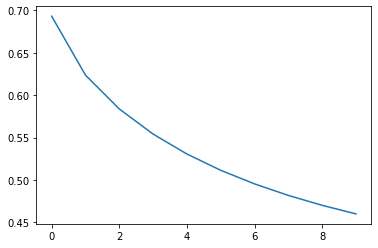

In [777]:
plt.plot(J_h)

###Checking the accuracy of the model

In [0]:
def predict(X, w, b):
  preds = X@w.t() + b
  return preds > 0

In [0]:
y_preds = predict(X_out, w, b).float()

In [780]:
print("train accuracy: {} %".format(100 - torch.mean(torch.abs(y_preds - y)) * 100))

train accuracy: 83.05084228515625 %


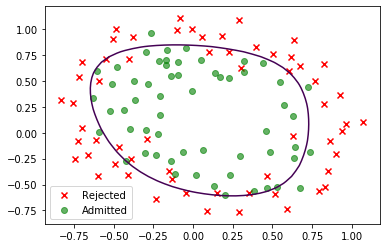

In [781]:
plot_decision_boundary(X)

##Applying regularization


**Last Exercise ;)**
Again experiment with different values for epochs, lr, but also for Lambda to obtain a regularized decision boundary similar to the one below.

![image](https://drive.google.com/uc?id=16UVx4_2_dO2PqkJqo8hSn5IL7F0BEEZT)

In [0]:
lr = 0.1
epochs = 1000
Lambda = 1

In [0]:
w, b, J_h = train(X_out, y, lr, epochs, Lambda)

In [832]:
y_preds_reg = predict(X_out, w, b).float()
print("train accuracy: {} %".format(100 - torch.mean(torch.abs(y_preds_reg - y)) * 100))

train accuracy: 74.5762710571289 %


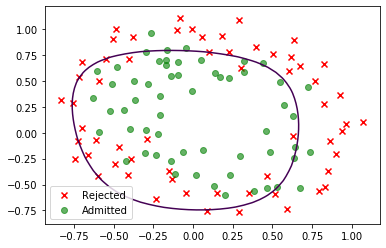

In [833]:
plot_decision_boundary(X)

**Remark**
In this HW, we tried to fix overfittin with regularization by judging based on visual outpusts. The purpose here was to show you the intuition behind what regularization does. In later HWs we'll do the same but will be judging based on numerical outputs. 